## Initializing functions

In [1]:
import csv
import pickle
import numpy as np
import random as rnd
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib as mpl
import pylab as plt
import os

# sets a pretty font for figures:
# mpl.rcParams['mathtext.fontset'] = 'stix'
# mpl.rcParams['font.family'] = 'STIXGeneral'

# set the current working directory (ensure it includes the data files):
os.chdir('<PATH>')  


""" identify when and how high the peak of a given population is """
def peak(array):
    array_max = max(array)
    index = list(array).index(array_max)
    return (t[index], array_max)  # <-- 't' is globally defined as the time to inegrate the model across

""" area gives the area under the curve given by array, a0 is an initial value to shift the area by"""
def area(array, steps, a0=0):
    a = np.zeros(len(steps))
    i = 0
    for r in steps:
        a[i] = sum(array[:r])
        i += 1
    return a * D/t_steps + a0 * np.ones(len(a))

""" cumul_30 gives the area under the curve given by array up to the 30th day """
def cumul_30(array, a0=0):
    a = np.zeros(30)
    i = 0
    for r in range(0, 30*dt, dt):
        a[i] = sum(array[:r])
        i += 1
    return (a * D/t_steps  + a0 * np.ones(len(a)))[-1]

""" Ro returns the reproductive ratio for our model, given the parameter values """
def Ro(ba, bi, bw, sa, si, eps, nuu, mui, muu, omeg, kk, pp):
    exit_rates = (eps + muu) * (mui + nuu) * (muu + omeg)
    zeta = eps * (ba * (mui + nuu) + bi * (1 - pp) * omeg) / exit_rates
    eta = 4 * eps * bw * (sa * (mui + nuu) + si * (1 - pp) * omeg) / (kk * exit_rates)
    return (zeta + np.sqrt(zeta**2 + eta))/2

""" returns total number infected over time iINCLUDING the environment """
def I_WAIT(days, ba, bi, bw, sa, si, eps):
    Y = odeint(dXdt, y0=X0, t=t, args=(ba, bi, bw, sa, si, eps))
    omega = 1/(inc_pd - eps)
    new_inf = (1 - p) * omega * Y[:, 2]
    return daily_cases(new_inf)

""" returns total number infected over time WITHOUT the environment """
def I_noWAIT(days, ba, bi, eps):
    Y = odeint(dXdt, y0=X0, t=t, args=(ba, bi, 0, 0, 0, eps))
    omega = 1/(inc_pd - eps)
    new_inf = (1 - p) * omega * Y[:, 2]
    return daily_cases(new_inf)

""" the Akaike Information Criterion is used to asses the validity of fits below """
def AIC(thry, data, k_theta):  # <-- k_theta is the number of fitting params
    """ taken from "AIC under the Framework of Least Squares Estimation"
        by H.T. Banks and Michele L. Joyner
    """
    N = len(data)
    sMLE = np.sqrt(sum((thry - data)**2) / N)  # <-- Maximum-likelihood estimate of std.
    a = - N * np.log(np.sqrt(2 * np.pi) * sMLE)
    b = - sum((thry - data)**2)/(2 * sMLE**2)
    aic = 2 * (k_theta - (a+b))  # <-- the Akaike Information Criterion (a+b is the log-likelihood)
    return aic

def daily_cases(array, num_days=30):
    day_steps = range(0, (num_days+1)*dt, dt)
    cases = np.zeros(num_days)
    for i in range(num_days):
        a, b = day_steps[i], day_steps[i+1]
        cases[i] = sum(array[a:b]) 
    return cases * D/t_steps

%matplotlib inline


# Model parameters -------------------------------------------------------------------------------#

D = 2*365               # number of days (SETS THE TIMESCALE OF THE PARAMETERS)
t_steps = 10**4         # number of integration steps (increase for better time resolution)
inc_pd = 5.5            # expected incubation period
dt = round(t_steps/D)           # number of integration steps per day
t = np.linspace(0, D, t_steps)  # Initializing the time over which to integrate (be mindful of the limits)


# FIXED ------------------------------#
nu = 0.03053968253968254  # = (1 - 0.038)/(4.5 * 7): assumes 3-6 weeks of recovery, 3.8% death rate
mu = 1/(80.3 * 365)       # 80.3 years is the avg. life expectancy of the 17 countries sampled (weighted by pop.)
muI = mu + 0.038/(3.5*7)  # assumes 3.8% death rate, and 3-4 weeks before death once symptomatic
k = 0.6486486486486486    # = 1/(avg. survival time)
p = 0.956                 # = fraction that move along the "mild" symptomatic route


# Initial conditions (population averaged across 17 countries sampled):
X0 = [57.05 * 10**6, 5*13.3, 13.3, 13.3, 0, 0.01]

# The model --------------------------------------------------------------------------------------#

def dXdt(X, t, bA, bI, bW, sA, sI, epsilon): # This function gives the derivatives of the appropriate populations @ t=0
    
    S = X[0]
    E = X[1]
    A = X[2]
    I = X[3]
    R = X[4]
    W = X[5]

    N = S + E + A + I + R
    L = (bA * A + bI * I)/N + bW * W
    
    omega = 1/(inc_pd - epsilon)
    
    dSdt = mu * (N - S) - L * S
    dEdt = L * S - (1/epsilon + mu) * E
    dAdt = (1/epsilon) * E - (omega + mu) * A
    dIdt = (1 - p) * omega * A - (nu + muI) * I
    dRdt = p * omega * A + nu * I - mu * R
    dWdt = (sA * A + sI * I) * (1 - W)/N - k * W

    return np.array([dSdt, dEdt, dAdt, dIdt, dRdt, dWdt])




## Plotting the model dynamics

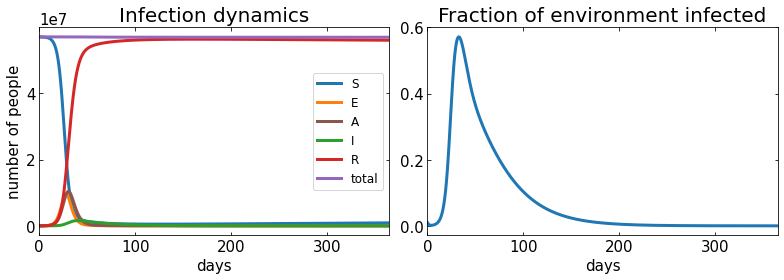

In [2]:
""" Average parameters """
bA = 0.5497938413115383
bI = 0.4909463148261044
bW = 0.031100446700197397
sA = 3.403914785083266
sI = 13.492166134223032
epsilon = 2.478385725999245
omega = 0.33094892640811974
mu = 3.411863047817261*10**(-5)
muI = 0.0015851390386414379
nu = 0.03053968253968254
k = 0.6486486486486486
p = 0.956

t = np.linspace(0, D, t_steps) 
Y = odeint(dXdt, y0=X0, t=t, args=(bA, bI, bW, sA, sI, epsilon))

S = Y[:, 0]
E = Y[:, 1]
A = Y[:, 2]
I = Y[:, 3]
R = Y[:, 4]
W = Y[:, 5]

""" plotting the SEAIR-W model """

xlim = 365

fig, ax = plt.subplots(1, 2, figsize = [11, 4])

plt.subplots_adjust(hspace = 0.4)

ax[0].plot(t, S, label = 'S', linewidth = 3, c = 'C0')
ax[0].plot(t, E, label = 'E', linewidth = 3, c = 'C1')
ax[0].plot(t, A, label = 'A', linewidth = 3, c = 'C5')
ax[0].plot(t, I, label = 'I', linewidth = 3, c = 'C2')
ax[0].plot(t, R, label = 'R', linewidth = 3, c = 'C3')
ax[0].plot(t, S + E + A + I + R, label = 'total', linewidth = 3, c = 'C4')
ax[1].plot(t, W, linewidth = 3)

ax[0].legend(fontsize = 12)
ax[0].set_title('Infection dynamics', fontsize = 20)
ax[0].set_xlim(0, xlim)
ax[0].set_ylabel('number of people', fontsize = 15)
ax[0].set_xlabel('days', fontsize = 15)
ax[0].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0, 1))
ax[1].set_xlabel('days', fontsize = 15)
ax[1].set_xlim(0, xlim)
ax[1].set_title('Fraction of environment infected', fontsize = 20)

for i in range(2):
    ax[i].yaxis.get_offset_text().set_fontsize(15)
    ax[i].tick_params(axis = 'both', direction = 'in', top = True, right = True, labelsize = 15)

plt.tight_layout()


## Fitting the model to each country

In [3]:
os.chdir('<PATH>')  

""" countries sampled """       
countries = ['United States']


# Collecting the populations ------------------------------#

file_name = 'country population.txt'

with open(file_name, 'r') as f:  
    reader = csv.reader(f)
    pops = list(reader)    

country_labels = [x[1] for x in pops]
    
country_pop = {}
for country in countries:
    country_index = country_labels.index(country)
    country_pop[country] = int(pops[country_index][-1])
    
""" we set the population of China to that of the approximate pop. of the Hubei province """
country_pop['China'] = 60*10**6

#----------------------------------------------------------#

# Collecting the total infected cases data ----------------#

""" retrieving the total counts data """
file_name1 = 'euro CDC CoV-19 data.txt'

with open(file_name1, 'r') as f:  
    reader = csv.reader(f)
    total_cases = list(reader)     
    
#----------------------------------------------------------#

# Collecting the daily new cases --------------------------#

""" retrieving the daily cases data """
file_name2 = 'euro CDC daily cases.txt'  

with open(file_name2, 'r') as f:  
    reader = csv.reader(f)
    new_cases = list(reader)    
    
#----------------------------------------------------------#


### SEIR-W (with environment)

In [4]:
%%time

""" RUN THE "Fitting the model to each country" CELL BEFORE RUNNING THIS CELL """

""" RUN THIS FOR THE MODEL INCLUDING THE ENVIRONMENT """

country_vals = {} # <-- to contain the (aic, popt, pcov) for each country
I0s = {}          # <-- to contain the initial count of susceptible folks

for country in country_pop:
    
    print(country)  # <-- this helps keep track of the progress
    
    #------------------------------------------------------#
    """ getting the country data """
    
    country_index = total_cases[0].index(country)
    
    country_total_cases = [int(total_cases[i][country_index]) for i in range(1, len(total_cases))]
    country_new_cases = [int(new_cases[i][country_index]) for i in range(1, len(new_cases))]
      
    start = 0
    for counts in country_total_cases:
        if counts >= 10:  # <-- we consider the first day greater or equal to 10 counts
            break
        start += 1
    
    new_cases_data = country_new_cases[start: start+30]  # <-- 30 days of data
    #------------------------------------------------------#

    I0 = country_total_cases[start]              # <-- initial symptomatic value
    I0s[country] = I0                            # <-- saved per country

    days = range(len(new_cases_data))
    
    # we use country-specific initial conditions:
    X0 = [country_pop[country], 5*I0, I0, I0, 0, 0.01]

    # running the fitting algorithm ------------------------------------------------------#
    init_params = [1.5] * 6  # <-- [bA, bI, bW, sA, sI, epsilon]
    bounds = ([0] * 6, [100, 100, 100, 100, 100, inc_pd*0.99])
    popt, pcov = curve_fit(I_WAIT, days, new_cases_data, p0=init_params, bounds=bounds)
    bA, bI, bW, sA, sI, epsilon = popt
    omega = 1/(inc_pd - epsilon)
    Y = odeint(dXdt, y0=X0, t=t, args=(bA, bI, bW, sA, sI, epsilon))
    new_cases_thry = daily_cases((1 - p) * omega * Y[:, 2])
    aic = AIC(new_cases_thry, new_cases_data, len(init_params))
    #-------------------------------------------------------------------------------------#
    
    country_vals[country] = (aic, popt, pcov)
    
    

United States
China
Wall time: 21.7 s


### SEIR (no environment)

In [5]:
%%time

""" RUN THE "Fitting the model to each country" CELL BEFORE RUNNING THIS CELL """

""" RUN THIS FOR THE MODEL WITHOUT THE ENVIRONMENT """

country_vals_noWAIT = {} # <-- to contain the (aic, popt, pcov) for each country
I0s = {}          # <-- to contain the initial count of susceptible folks

for country in country_pop:
    
    print(country)
    
    #------------------------------------------------------#
    country_index = total_cases[0].index(country)
    
    country_total_cases = [int(total_cases[i][country_index]) for i in range(1, len(total_cases))]
    country_new_cases = [int(new_cases[i][country_index]) for i in range(1, len(new_cases))]
      
    start = 0
    for counts in country_total_cases:
        if counts >= 10:  # <-- we consider the first day greater or equal to 10 counts
            break
        start += 1
    
    new_cases_data = country_new_cases[start: start+30]  # <-- 30 days of data
    #------------------------------------------------------#

    I0 = country_total_cases[start]              # <-- initial symptomatic value
    
    I0s[country] = I0                   # <-- saved per country

    days = range(len(new_cases_data))

    X0 = [country_pop[country], 5*I0, I0, I0, 0, 0.01]

    init_params = [1.5]*3  # <-- [bA, bI, epsilon]
    bounds = ([0] * 3, [100, 100, inc_pd*0.99])
    popt, pcov = curve_fit(I_noWAIT, days, new_cases_data, p0=init_params, bounds=bounds)
    bA, bI, epsilon = popt
    omega = 1/(inc_pd - epsilon)
    Y = odeint(dXdt, y0=X0, t=t, args=(bA, bI, 0, 0, 0, epsilon))
    new_cases_thry = daily_cases((1 - p) * omega * Y[:, 2])
    aic = AIC(new_cases_thry, new_cases_data, len(init_params))

    country_vals_noWAIT[country] = (aic, popt, pcov)
    

United States
China
Wall time: 3.76 s


### Plotting the fits for a specific country

In [6]:
""" RUN THIS CELL BEFORE RUNNING INDIVIDUAL FITS BELOW """

""" We fit: bA, bI, bW, sA, sI, epsilon """

""" countries sampled """   
countries = ['United States']
             

# Collecting the populations ------------------------------#

file_name = 'country population.txt'

with open(file_name, 'r') as f:  
    reader = csv.reader(f)
    pops = list(reader)    

country_labels = [x[1] for x in pops]
    
country_pop = {}
for country in countries:
    country_index = country_labels.index(country)
    country_pop[country] = int(pops[country_index][-1])
    
""" we set the population of China to that of the approximate pop. of the Hubei province """
country_pop['China'] = 60*10**6

#----------------------------------------------------------#

# Collecting the total infected cases data ----------------#

""" retrieving the total counts data """
file_name1 = 'euro CDC CoV-19 data.txt'

with open(file_name1, 'r') as f:  
    reader = csv.reader(f)
    total_cases = list(reader)     
    
#----------------------------------------------------------#

# Collecting the daily new cases --------------------------#

""" retrieving the daily cases data """
file_name2 = 'euro CDC daily cases.txt'  

with open(file_name2, 'r') as f:  
    reader = csv.reader(f)
    new_cases = list(reader)    
    
#----------------------------------------------------------#


In [7]:
#------------------------------------------------------#

""" pick a country! """

country = "United States"

country_index = total_cases[0].index(country)
    
country_total_cases = [int(total_cases[i][country_index]) for i in range(1, len(total_cases))]
country_new_cases = [int(new_cases[i][country_index]) for i in range(1, len(new_cases))]

start = 0
for counts in country_total_cases:
    if counts >= 10:  # <-- we consider the first day greater or equal to 10 counts
        break
    start += 1

new_cases_data = country_new_cases[start: start+30]  # <-- 30 days of data

#------------------------------------------------------#

I0 = country_total_cases[start]                    # <-- initial symptomatic value

days = range(len(new_cases_data))

X0 = [country_pop[country], 5*I0, I0, I0, 0, 0.01]

thry_aic = {}

# Fitting the model --------------------------------------------------------------------------#

for i in range(2):
    
    if i == 0 :
        
        # with environment ---------------------------------#

        init_params = [1.5] * 6  # <-- [bA, bI, bW, sA, sI, epsilon]
        bounds = ([0] * 6, [100, 100, 100, 100, 100, inc_pd*0.99])
        popt, pcov = curve_fit(I_WAIT, days, new_cases_data, p0=init_params, bounds=bounds)
        bA, bI, bW, sA, sI, epsilon = popt
        omega = 1/(inc_pd - epsilon)
        Y = odeint(dXdt, y0=X0, t=t, args=(bA, bI, bW, sA, sI, epsilon))
        new_cases_thry = daily_cases((1 - p) * omega * Y[:, 2])
        aic = AIC(new_cases_thry, new_cases_data, len(init_params))
        thry_aic['SEIR-W'] = (new_cases_thry, aic)

        #---------------------------------------------------#

    else:
        
        # without environment ------------------------------#

        init_params = [1.5] * 3  # <-- [bA, bI, epsilon]
        bounds = ([0] * 3, [100, 100, inc_pd*0.99])
        popt, pcov = curve_fit(I_noWAIT, days, new_cases_data, p0=init_params, bounds=bounds)
        bA, bI, epsilon = popt
        omega = 1/(inc_pd - epsilon)
        Y = odeint(dXdt, y0=X0, t=t, args=(bA, bI, 0, 0, 0, epsilon))
        new_cases_thry = daily_cases((1 - p) * omega * Y[:, 2])
        aic = AIC(new_cases_thry, new_cases_data, len(init_params))
        thry_aic['SEIR'] = (new_cases_thry, aic)

        #---------------------------------------------------#

#---------------------------------------------------------------------------------------------#




